In [72]:
# Packages
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import hdbscan

os.chdir("C:/Users/Soledad.Acuna/Desktop/tesis/data")

# Load the data
sociodemo = pd.read_excel("sociodemographic.xlsx")
banks = pd.read_excel("banks_location.xlsx")
business = pd.read_excel("business.xlsx")

SECTION 1: Clean and aggregate each data frame by district 

1. BAKNS

- From CUSEC column, create district column.
- Normalized names of the entity column and keep only the 5 competitors banks (Sabadell, BBVA, Santander, CaixaBank and Bankinter).
- Aggregate the data by district and entity, adding the number of branches.
- Create a new data frame (banks_district_final) that contains the number of banks (total and by entity) per district.

In [73]:
banks['CUSEC'] = banks['CUSEC'].astype(str)
# Create 'district' column (CUSEC without the last 3 digits)
banks['district'] = banks['CUSEC'].str[:-3]

# Function to normalize names of banks in the "ENTITY" column
def normalize_entity(e):
    e = str(e).strip().upper()
    if e == 'CAIXABANK':
        return 'CaixaBank'
    elif e in ['SANTANDER', 'BANCO SANTANDER']:
        return 'Santander'
    elif e in ['BBVA', 'BANCO BILBAO VIZCAYA ARGENTARIA']:
        return 'BBVA'
    elif e in ['BANCO DE SABADELL', 'SABADELL']:
        return 'Sabadell'
    elif e == 'BANKINTER':
        return 'Bankinter'
    else:
        return 'Others'
    
# Apply the function to the original column
banks['entity'] = banks['ENTITY'].apply(normalize_entity)

# Keep only the 5 top entities
banks = banks[banks['entity'] != 'Others']

# Group by district and entity, adding the number of branches
banks_district = banks.groupby(['district', 'entity'])['NUM_BRANCHES'].sum().reset_index()

# Pivot so that each entity is in a column
banks_district_final = banks_district.pivot(index='district', columns='entity', values='NUM_BRANCHES').fillna(0)

# Rename columns
banks_district_final.columns.name = None
banks_district_final = banks_district_final.rename(columns={'CaixaBank': 'banks_CaixaBank', 'Santander': 'banks_Santander', 'Sabadell': 'banks_Sabadell', 'Bankinter': 'banks_Bankinter', 'BBVA': 'Banks_BBVA'})

# Create column with the total number of banks (adding the 5 entity columns)
banks_district_final['banks_total'] = banks_district_final.sum(axis=1)

# Reset index so that district is a column
banks_district_final = banks_district_final.reset_index()

2. SOCIODEMOGRAPHIC

- From CUSEC column, create district column.
- Create "high" column which contains the number of high income people in each CUSEC.
- Create “professional” column which contains the number of professionals in each CUSEC. This variable include managers, technicians, skilled workers and entrepreneurs.
- To aggregate in a correct way "high" and "professional" columns in district level, we created weighted columns for both variables as the product of each one and the population on each CUSEC. Then, we aggregate this weighted variables and the total population to obtain district levels. Finally, to obtain the "high" and "professionals" columns in district terms, we divided both aggregated variables with the total population of each district.
- Create new data frame (sociodemo_district_final) that contains "high", "professionals" and "tot_pop" per district. 

In [74]:
sociodemo['CUSEC'] = sociodemo['CUSEC'].astype(str)
# Create 'district' column (CUSEC without the last 3 digits)
sociodemo['district'] = sociodemo['CUSEC'].str[:-3]

# Create columns
sociodemo['high'] = (sociodemo['v_nse6'] + sociodemo['v_nse7'] + sociodemo['v_nse8'] + sociodemo['v_nse9'])
sociodemo['professionals'] = (sociodemo['v_deyap'] + sociodemo['v_tpcint'] + sociodemo['v_tprda'] + sociodemo['v_tcuap'] + sociodemo['v_emspr'] + sociodemo['v_atcim'] + sociodemo['v_emnpr'])

# Name of the variables to be weighted 
variables = ['nse']  

# Create weighted columns
for variable in variables:
    sociodemo[f'{variable}_pond'] = sociodemo[variable] * sociodemo['tot_pob']

# Group by district
grouped = sociodemo.groupby('district').agg({
    **{f'{v}_pond': 'sum' for v in variables},
    'tot_pob': 'sum',
    'high': 'sum',
    'professionals': 'sum'
}).reset_index()

# Calculate the weighted district variables 
for variable in variables:
    grouped[f'{variable}_district'] = grouped[f'{variable}_pond'] / grouped['tot_pob']

# Keep only final columns and tot_pob
final_columns = ['district', 'tot_pob', 'high', 'professionals'] + [f'{v}_district' for v in variables]
sociodemo_district_final = grouped[final_columns]

In [ ]:
sociodemo_district_final

3. BUSINESS

- Fill missing values with 0, assuming that columns with missing values dont have companies in the respective category (num of companies, num of new companies, billing and profit ranges...).
- From CUSEC column, create district column.
- Aggregate all the data in district levels (all columns represent number of companies).
- Previously, we obtained the top 10 sectors which starts with the letters: ('F', 'G', 'J', 'M', 'I', 'N', 'C', 'H', 'L', 'R').
- We want to create a data frame that contain the following columns: Number of companies of the 10 top sectors, Number of New Companies of the top 10 sectors, Number of medium and big companies of the top 10 sectors and Number of High Profit Companies of the Top 10 sectors. For this, we create 4 subsets from the business df:
1. Subset 1: use the columns of the business df that contain the Number of companies by sector and aggregate those of the 10 sectors to obtain NumCompanies_10S.
2. Subset 2: use the columns of the business df that contain the Number of New companies by sector and aggregate those of the 10 sectors to obtain NumNewCompanies_10S.
3. Subset 3: use the columns of the business df that contain the number of companies of each billing ranges by sector. However, this columns names are in division categories (01 to 99), so we created a dictionary and a function to match and replace each division (01 to 99) to each section (A to U) and selected only the columns associated to the top 10 sectors. Then we filtered by columns where the billing ranges represents medium and big companies (more than 5000001 billings). Finally we agregate that columns to obtain NumCompanies_ML_10S.
4. Subset 4: use the columns of the business df that contain the number of companies of each profit ranges by sector. However, this columns names are in division categories (01 to 99) so we created a dictionary and a function to match and replace each division (01 to 99) to each section (A to U) and selected only the columns associated to the top 10 sectors. Then we filtered by columns where the profit ranges represents high profit companies (more than 100001 profits). Finally we agregate that columns to obtain NumCompanies_HP_10S.
- Merge all subsets to create business_district_final wich contains 5 columns: district, NumCompanies_10S, NumNewCompanies_10S, NumCompanies_ML_10S and NumCompanies_HP_10S

In [75]:
business.fillna(0, inplace=True)
business['CUSEC'] = business['CUSEC'].astype(str)
# Create 'district' column (CUSEC without the last 3 digits)
business['district'] = business['CUSEC'].str[:-3]

business = business.drop(columns=['CUSEC'])

# Group by district and add all companies
business_district = business.groupby('district').sum().reset_index()

Subset 1: Number of Companies Top 10 sectors

In [76]:
# Select the columns that contain the Number of companies by sector
cols1 = list(business_district.columns[:22])
business_subset1 = business_district[cols1]

# Letters of the 10 sectors
letters = ('F', 'G', 'J', 'M', 'I', 'N', 'C', 'H', 'L', 'R')

# Filter columns that begin with that letters
filtered_columns = [col for col in business_subset1.columns if col.startswith(letters)]

# Create a new df with that columns and district 
business_subset1 = business_subset1[['district'] + filtered_columns]

# Aggregate that columns to obtain the number of companies of the 10 sectors by district
sector_columns = [col for col in business_subset1.columns if col != 'district']
business_subset1['NumCompanies_10S'] = business_subset1[sector_columns].sum(axis=1)

# business_1 contains two columns: district and NumCompanies_10S
business_1 = business_subset1[['district', 'NumCompanies_10S']]

Subset 2: Number of New Companies Top 10 sectors

In [77]:
# Select the columns that contain the Number of New companies by sector
cols2 = ['district'] + list(business_district.columns[22:42])
business_subset2 = business_district[cols2]

# Letters of the 10 sectors
letters = ('F', 'G', 'J', 'M', 'I', 'N', 'C', 'H', 'L', 'R')

# Filter columns that begin with that letters
filtered_columns = [col for col in business_subset2.columns if col.startswith(letters)]

# Create a new df with that columns and district 
business_subset2 = business_subset2[['district'] + filtered_columns]

# Aggregate that columns to obtain the number of new companies of the 10 sectors by district
sector_columns = [col for col in business_subset2.columns if col != 'district']
business_subset2['NumNewCompanies_10S'] = business_subset2[sector_columns].sum(axis=1)

# business_2 contains two columns: district and NumNewCompanies_10S
business_2 = business_subset2[['district', 'NumNewCompanies_10S']]

Subset 3: Number of Medium and Big Companies Top 10 sectors

In [78]:
# Select the columns that contain the range of billings by sector 
cols3 = ['district'] + list(business_district.columns[528:1282])
business_subset3 = business_district[cols3]

import re
# 1. Create the dictionary to match each division (01 to 99) to each section (A to U)
# (the columns of billing ranges by sector are in division categories)
division_to_section = {
    'A': list(range(1, 4)),        # 01 a 03
    'B': list(range(5, 10)),       # 05 a 09
    'C': list(range(10, 34)),      # 10 a 33
    'D': [35],                    # 35
    'E': list(range(36, 40)),      # 36 a 39
    'F': list(range(41, 44)),      # 41 a 43
    'G': list(range(45, 48)),      # 45 a 47
    'H': list(range(49, 54)),      # 49 a 53
    'I': list(range(55, 57)),      # 55 a 56
    'J': list(range(58, 64)),      # 58 a 63
    'K': list(range(64, 67)),      # 64 a 66
    'L': [68],                    # 68
    'M': list(range(69, 76)),      # 69 a 75
    'N': list(range(77, 83)),      # 77 a 82
    'O': [84],                    # 84
    'P': [85],                    # 85
    'Q': list(range(86, 89)),      # 86 a 88
    'R': list(range(90, 94)),      # 90 a 93
    'S': list(range(94, 97)),      # 94 a 96
    'T': [97],                    # 97
    'U': [99],                    # 99
}

# 2. Function to map the number to the section code
def map_to_section(col_name):
    # Find the number at the start
    match = re.match(r'^(\d{2})_', col_name)
    if match:
        num = int(match.group(1))
        for section, divisions in division_to_section.items():
            if num in divisions:
                # Replace the part before the first '_' with the section letter
                parts = col_name.split('_')
                new_col = section + '_' + '_'.join(parts[1:])
                return new_col
    return col_name  # If it doesn't match, return the original

# 3. Apply the function to all columns
new_columns = [map_to_section(col) for col in business_subset3.columns]

# 4. Reassign column names
business_subset3.columns = new_columns

# Filter only columns that end with those texts that represents medium and big companies
cols_big_medium = [col for col in business_subset3.columns if 
                   col.endswith('Between5000001And25000000_Billing') or
                   col.endswith('Between25000001And50000000_Billing') or
                   col.endswith('MoreThan50000000_Billing')]

# Create the new df with this columns
business_subset3 = business_subset3[['district'] + cols_big_medium]

# Letters of the 10 sectors
letters = ('F', 'G', 'J', 'M', 'I', 'N', 'C', 'H', 'L', 'R')

# Filter columns that begin with that letters
filtered_columns = [col for col in business_subset3.columns if col.startswith(letters)]

# Create a new df with that columns and district
business_subset3 = business_subset3[['district'] + filtered_columns]

# Aggregate that columns to obtain the number of companies medium and big of the 10 sectors by district
sector_columns = [col for col in business_subset3.columns if col != 'district']
business_subset3['NumCompanies_ML_10S'] = business_subset3[sector_columns].sum(axis=1)

# business_3 contains two columns: district and NumCompanies_ML_10S
business_3 = business_subset3[['district', 'NumCompanies_ML_10S']]

Subset 4: Number of High Profit Companies Top 10 sectors

In [79]:
# Select the columns that contain the range of profit by sector
cols4 = ['district'] + list(business_district.columns[48:498])
business_subset4 = business_district[cols4]

import re
# 1. Create the dictionary to match each division (01 to 99) to each section (A to U)
# (the columns of profit ranges by sector are in division categories)
division_to_section = {
    'A': list(range(1, 4)),        # 01 a 03
    'B': list(range(5, 10)),       # 05 a 09
    'C': list(range(10, 34)),      # 10 a 33
    'D': [35],                    # 35
    'E': list(range(36, 40)),      # 36 a 39
    'F': list(range(41, 44)),      # 41 a 43
    'G': list(range(45, 48)),      # 45 a 47
    'H': list(range(49, 54)),      # 49 a 53
    'I': list(range(55, 57)),      # 55 a 56
    'J': list(range(58, 64)),      # 58 a 63
    'K': list(range(64, 67)),      # 64 a 66
    'L': [68],                    # 68
    'M': list(range(69, 76)),      # 69 a 75
    'N': list(range(77, 83)),      # 77 a 82
    'O': [84],                    # 84
    'P': [85],                    # 85
    'Q': list(range(86, 89)),      # 86 a 88
    'R': list(range(90, 94)),      # 90 a 93
    'S': list(range(94, 97)),      # 94 a 96
    'T': [97],                    # 97
    'U': [99],                    # 99
}

# 2. Function to map the number to the section code
def map_to_section(col_name):
    # Find the number at the start
    match = re.match(r'^(\d{2})_', col_name)
    if match:
        num = int(match.group(1))
        for section, divisions in division_to_section.items():
            if num in divisions:
                # Replace the part before the first '_' with the section letter
                parts = col_name.split('_')
                new_col = section + '_' + '_'.join(parts[1:])
                return new_col
    return col_name  #  If it doesn't match, return the original

# 3. Apply the function to all columns
new_columns = [map_to_section(col) for col in business_subset4.columns]

# 4. Reassign column names
business_subset4.columns = new_columns

# Filter only columns that end with those texts that represents high profit companies
cols_profit = [col for col in business_subset4.columns if 
                   col.endswith('Between100001And500000_Profit') or
                   col.endswith('Between500001And1000000_Profit') or
                   col.endswith('MoreThan1000000_Profit')]

# Create the new df with this columns
business_subset4 = business_subset4[['district'] + cols_profit]

# Letters of the 10 sectors
letters = ('F', 'G', 'J', 'M', 'I', 'N', 'C', 'H', 'L', 'R')

# Filter columns that begin with that letters
filtered_columns = [col for col in business_subset4.columns if col.startswith(letters)]

# Create a new df with that columns and district
business_subset4 = business_subset4[['district'] + filtered_columns]

# Aggregate that columns to obtain the number of companies with high profits of the 10 sectors by district
sector_columns = [col for col in business_subset4.columns if col != 'district']
business_subset4['NumCompanies_HP_10S'] = business_subset4[sector_columns].sum(axis=1)

# business_4 contains two columns: district and NumCompanies_HP_10S
business_4 = business_subset4[['district', 'NumCompanies_HP_10S']]

In [80]:
# Merge all subsets by the "district" column to obtain business_district_final
business_district_final = business_1.merge(business_2, on='district', how='outer')
business_district_final = business_district_final.merge(business_3, on='district', how='outer')
business_district_final = business_district_final.merge(business_4, on='district', how='outer')

Merge the following datasets. The resulting dataset is called "df":
- sociodemo_district_final
- business_district_final
- banks_district final

SECTION 2: MERGE

In [81]:
# Merge the three datasets into one per district
df = sociodemo_district_final.merge(business_district_final, on='district', how='outer')
df = df.merge(banks_district_final, on='district', how='left')
# Replace NaNs presents in banks columns with 0, assuming there are no banks (or entity banks) in that district
df.fillna(0, inplace=True)

In [82]:
df.to_csv("df_merged.csv", index=False)

In [151]:
df = pd.read_csv("df_merged.csv")

SECTION 3: FEATURE ENGINEER

- Calculate ratios adjusting by population in sociodemographic variables and by the number of companies in the 10 sectors in business variables.
- Create growth rate of companies of the 10 sectors 
- Scaled the features
- Create composite scores: These capture both absolute frequency (number of scores) and relative density (percentage). This is because the bank may be interested in both market volume and target concentration.

In [152]:
# Calculate ratios adjusting by population in sociodemographic variables
df['high_district_ratio'] = df['high'] / df['tot_pob']
df['professionals_district_ratio'] = df['professionals'] / df['tot_pob']

# Calculate the growth rate of companies of the 10 sectors
df['growth_rate_10S'] = df['NumNewCompanies_10S'] / df['NumCompanies_10S']

# Calculate ratios adjusting by the number of companies in the 10 sectors in business variables
df['companies_size_ratio_10S'] = df['NumCompanies_ML_10S'] / df['NumCompanies_10S']
df['companies_profit_ratio_10S'] = df['NumCompanies_HP_10S'] / df['NumCompanies_10S']

# Some created ratios have missing values because both the numerator and denominator of the ratio are zeros. Therefore, we impute these values ​​as zeros.
df.fillna(0, inplace=True)

In [153]:
df['district'] = df['district'].astype(str)
df['province'] = df['district'].apply(lambda x: 'Madrid' if x.startswith('28') else 'Cataluña')

df_cataluna = df[df['province'] == 'Cataluña'].copy()
df_madrid = df[df['province'] == 'Madrid'].copy()

SECTION 4: CLUSTERING AND SCORE

MADRID

In [154]:
columns_to_score = [
    'high',
    'high_district_ratio',
    'professionals',
    'professionals_district_ratio',
    'NumCompanies_10S',
    'NumNewCompanies_10S',
    'growth_rate_10S',
    'NumCompanies_ML_10S',
    'companies_size_ratio_10S',
    'NumCompanies_HP_10S',
    'companies_profit_ratio_10S',
    'banks_total'
]

for col in columns_to_score:
    lower = df_madrid[col].quantile(0.05)
    upper = df_madrid[col].quantile(0.95)
    
    # Normalización entre percentil 5 y 95
    score = (df_madrid[col] - lower) / (upper - lower) * 100
    score = score.clip(lower=0, upper=100)
    
    # Asignar la nueva columna
    df_madrid[f'{col}_score'] = score

In [155]:
# Create engineered features from scaled data 
# sociodemo_Score: Considera la frecuencia de personas de altos ingresos y profesionales y el porcentaje de ambos en la población de cada distrito  
df_madrid['sociodemo_Score'] = 0.25*(
    df_madrid['high_score'] +
    df_madrid['high_district_ratio_score'] +
    df_madrid['professionals_score'] +
    df_madrid['professionals_district_ratio_score']
)

# Business_Score: 60%: Considera la frecuencia de empresas medianas y grandes de los 10 sectores y el porcentaje de ellas en el total de empresas de los 10 sectores.
# 40%: Considera la frecuencia de empresas high profit de los 10 sectores y el porcentaje de ellas en el total de empresas de los 10 sectores, además del número de nuevas empresas de los 10 sectores y la tasa de crecimiento de los 10 sectores.
df_madrid['Business_Score'] = (0.6*(df_madrid['NumCompanies_ML_10S_score'] + df_madrid['companies_size_ratio_10S_score']) + 
                        0.2*(df_madrid['NumCompanies_HP_10S_score'] + df_madrid['companies_profit_ratio_10S_score']) + 
                        0.2*(df_madrid['NumNewCompanies_10S_score'] + df_madrid['growth_rate_10S_score'])
                        )

df_madrid['Competitor_Score'] = 100 - df_madrid['banks_total_score']

In [156]:
# Features a usar
score_features = ['sociodemo_Score', 'Business_Score', 'Competitor_Score']

# Estandarizar
scaler_madrid = MinMaxScaler()
df_scaled_madrid = pd.DataFrame(
    scaler_madrid.fit_transform(df_madrid[score_features]),
    columns=[f"{col}_norm" for col in score_features],
    index=df_madrid.index
)

df_madrid = pd.concat([df_madrid, df_scaled_madrid], axis=1)

# Clustering
clusterer_madrid = hdbscan.HDBSCAN(min_cluster_size=10, prediction_data=True)
df_madrid['hdbscan_cluster'] = clusterer_madrid.fit_predict(df_scaled_madrid)

print(df_madrid['hdbscan_cluster'].value_counts().sort_index())

hdbscan_cluster
-1      6
 0     14
 1    226
Name: count, dtype: int64


In [157]:
df_madrid[df_madrid['hdbscan_cluster'] >= -1].groupby('hdbscan_cluster')[
    ['sociodemo_Score_norm', 'Business_Score_norm', 'Competitor_Score_norm']
].mean()

,sociodemo_Score_norm,Business_Score_norm,Competitor_Score_norm
hdbscan_cluster,,,
-1,0.650755,0.700336,0.385965
0,0.789280,0.740817,0.021303
1,0.207793,0.199077,0.914920


In [158]:
# Compute Zone_Score using weighted business logic (manual inputs for weights)
df_madrid['Zone_Score'] = (
    0.45 * df_madrid['sociodemo_Score_norm'] +
    0.45 * df_madrid['Business_Score_norm'] +
    0.1 * df_madrid['Competitor_Score_norm']
)

# Get top 10 zones per region
top10 = df_madrid.nlargest(10, 'Zone_Score')[['district', 'Zone_Score', 'hdbscan_cluster']]
top10.reset_index(drop=True)

,district,Zone_Score,hdbscan_cluster
0,2807905,0.795884,0
1,2807909,0.775077,0
2,2807903,0.766972,0
3,2807904,0.764358,0
4,2811501,0.757524,-1
5,2807907,0.754176,0
6,2890301,0.742783,-1
7,2807916,0.740270,0
8,2812701,0.733868,-1
9,2807908,0.712021,0


CATALUÑA

In [159]:
columns_to_score = [
    'high',
    'high_district_ratio',
    'professionals',
    'professionals_district_ratio',
    'NumCompanies_10S',
    'NumNewCompanies_10S',
    'growth_rate_10S',
    'NumCompanies_ML_10S',
    'companies_size_ratio_10S',
    'NumCompanies_HP_10S',
    'companies_profit_ratio_10S',
    'banks_total'
]

for col in columns_to_score:
    lower = df_cataluna[col].quantile(0.05)
    upper = df_cataluna[col].quantile(0.95)
    
    # Normalización entre percentil 5 y 95
    score = (df_cataluna[col] - lower) / (upper - lower) * 100
    score = score.clip(lower=0, upper=100)
    
    # Asignar la nueva columna
    df_cataluna[f'{col}_score'] = score


In [160]:
# Create engineered features from scaled data 
# sociodemo_Score: Considera la frecuencia de personas de altos ingresos y profesionales y el porcentaje de ambos en la población de cada distrito  
df_cataluna['sociodemo_Score'] = 0.25*(
    df_cataluna['high_score'] +
    df_cataluna['high_district_ratio_score'] +
    df_cataluna['professionals_score'] +
    df_cataluna['professionals_district_ratio_score']
)

# Business_Score: 60%: Considera la frecuencia de empresas medianas y grandes de los 10 sectores y el porcentaje de ellas en el total de empresas de los 10 sectores.
# 40%: Considera la frecuencia de empresas high profit de los 10 sectores y el porcentaje de ellas en el total de empresas de los 10 sectores, además del número de nuevas empresas de los 10 sectores y la tasa de crecimiento de los 10 sectores.
df_cataluna['Business_Score'] = (0.6*(df_cataluna['NumCompanies_ML_10S_score'] + df_cataluna['companies_size_ratio_10S_score']) + 
                        0.2*(df_cataluna['NumCompanies_HP_10S_score'] + df_cataluna['companies_profit_ratio_10S_score']) + 
                        0.2*(df_cataluna['NumNewCompanies_10S_score'] + df_cataluna['growth_rate_10S_score'])
                        )

df_cataluna['Competitor_Score'] = 100 - df_cataluna['banks_total_score']

In [161]:
# Features a usar
score_features = ['sociodemo_Score', 'Business_Score', 'Competitor_Score']

# Estandarizar
scaler_cataluna = MinMaxScaler()
df_scaled_cataluna = pd.DataFrame(
    scaler_cataluna.fit_transform(df_cataluna[score_features]),
    columns=[f"{col}_norm" for col in score_features],
    index=df_cataluna.index
)

df_cataluna = pd.concat([df_cataluna, df_scaled_cataluna], axis=1)

# Clustering
clusterer_cataluna = hdbscan.HDBSCAN(min_cluster_size=10, prediction_data=True)
df_cataluna['hdbscan_cluster'] = clusterer_cataluna.fit_predict(df_scaled_cataluna)

print(df_cataluna['hdbscan_cluster'].value_counts().sort_index())

hdbscan_cluster
-1    122
 0     26
 1     45
 2     59
 3    113
 4    251
 5    623
Name: count, dtype: int64


In [162]:
df_cataluna[df_cataluna['hdbscan_cluster'] >= -1].groupby('hdbscan_cluster')[
    ['sociodemo_Score_norm', 'Business_Score_norm', 'Competitor_Score_norm']
].mean()

,sociodemo_Score_norm,Business_Score_norm,Competitor_Score_norm
hdbscan_cluster,,,
-1,0.529340,0.549733,0.422951
0,0.453989,0.343063,0.200000
1,0.581374,0.548610,0.000000
2,0.307162,0.284968,0.400000
3,0.245055,0.243730,0.600000
4,0.250258,0.189899,0.800000
5,0.227381,0.167450,1.000000


In [163]:
# Compute Zone_Score using weighted business logic (manual inputs for weights)
df_cataluna['Zone_Score'] = (
    0.45 * df_cataluna['sociodemo_Score_norm'] +
    0.45 * df_cataluna['Business_Score_norm'] +
    0.1 * df_cataluna['Competitor_Score_norm']
)

# Get top 10 zones per region
top10 = df_cataluna.nlargest(10, 'Zone_Score')[['district', 'Zone_Score', 'hdbscan_cluster']]
top10.reset_index(drop=True)

,district,Zone_Score,hdbscan_cluster
0,820502,0.847696,-1
1,822101,0.789100,-1
2,820505,0.779641,-1
3,823801,0.773342,-1
4,820501,0.764942,-1
5,805604,0.762607,-1
6,801905,0.753875,-1
7,801904,0.747559,-1
8,805605,0.728141,-1
9,801902,0.727801,1


In [35]:
top_distritos = df.sort_values(by='Zone_Score', ascending=False).head(10)
print(top_distritos[['district', 'Zone_Score']])

# Lista de códigos de los 10 mejores distritos
lista_top10_distritos = top_distritos['district'].tolist()
print(lista_top10_distritos)

# Asegurate de que ambos sean del mismo tipo (int o str)
df['district'] = df['district'].astype(int)
lista_top10_distritos = [int(d) for d in lista_top10_distritos]

# Crear columna 'top': 1 si está en la lista, 0 si no
df['top'] = df['district'].isin(lista_top10_distritos).astype(int)

      district  Zone_Score
623    2807904    0.752596
1025    801905    0.677813
624    2807905    0.650775
1022    801902    0.650253
626    2807907    0.629157
635    2807916    0.548073
627    2807908    0.543497
634    2807915    0.525239
625    2807906    0.497897
622    2807903    0.481116
[2807904, 801905, 2807905, 801902, 2807907, 2807916, 2807908, 2807915, 2807906, 2807903]


In [22]:
df['cluster'] = np.where(df['hdbscan_cluster'] == -1, 1, 0)

In [23]:
census = gpd.read_file("census.gpkg")
df['district'] = df['district'].astype(str)
# Realizar la unión manteniendo la geometría de 'census'
census_merged = census.merge(df, on='district', how='left')
census_merged.fillna(0, inplace=True)

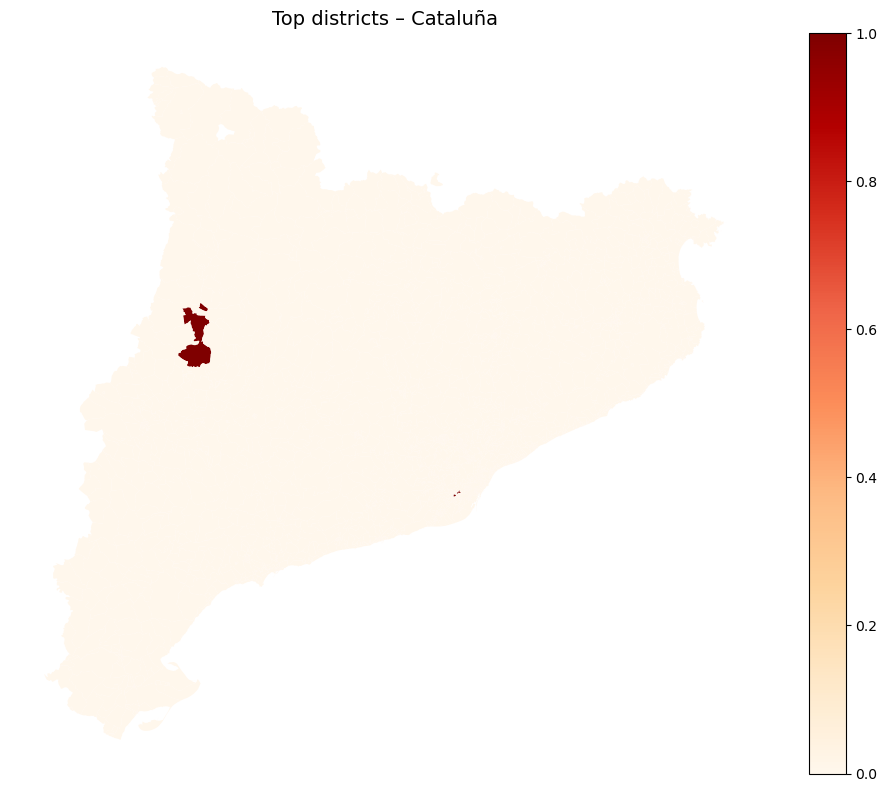

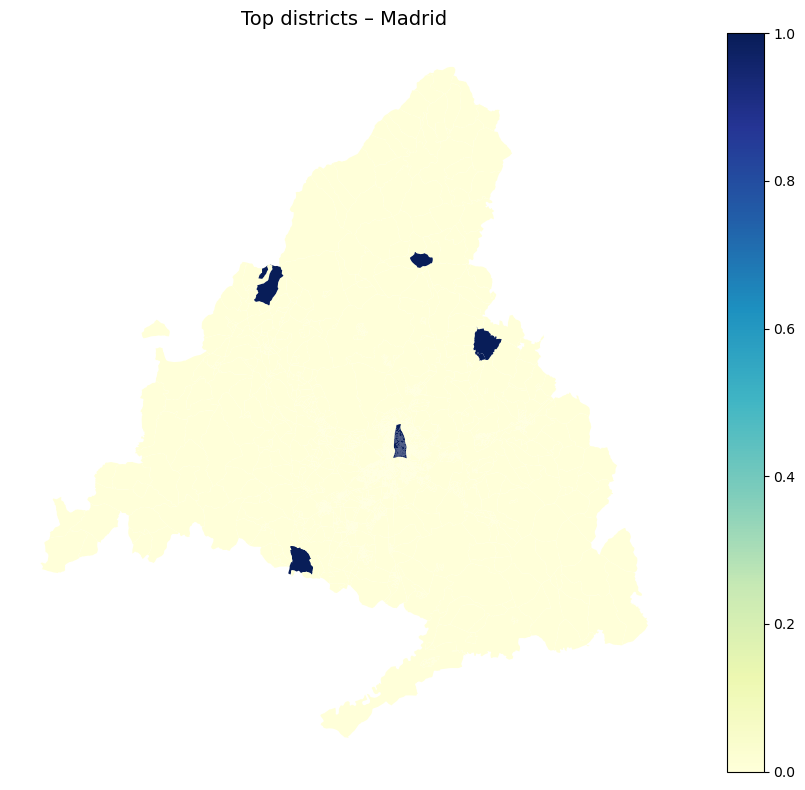

In [24]:
# Separar por provincia
resumen_cat = census_merged[census_merged['province'] == 'Cataluña']
resumen_mad = census_merged[census_merged['province'] == 'Madrid']

# Mapa de Cataluña
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
resumen_cat.plot(column='top', cmap='OrRd', linewidth=0.1, legend=True, ax=ax)
ax.set_title("Top districts – Cataluña", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

# Mapa de Madrid
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
resumen_mad.plot(column='top', cmap='YlGnBu', linewidth=0.1, legend=True, ax=ax)
ax.set_title("Top districts – Madrid", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


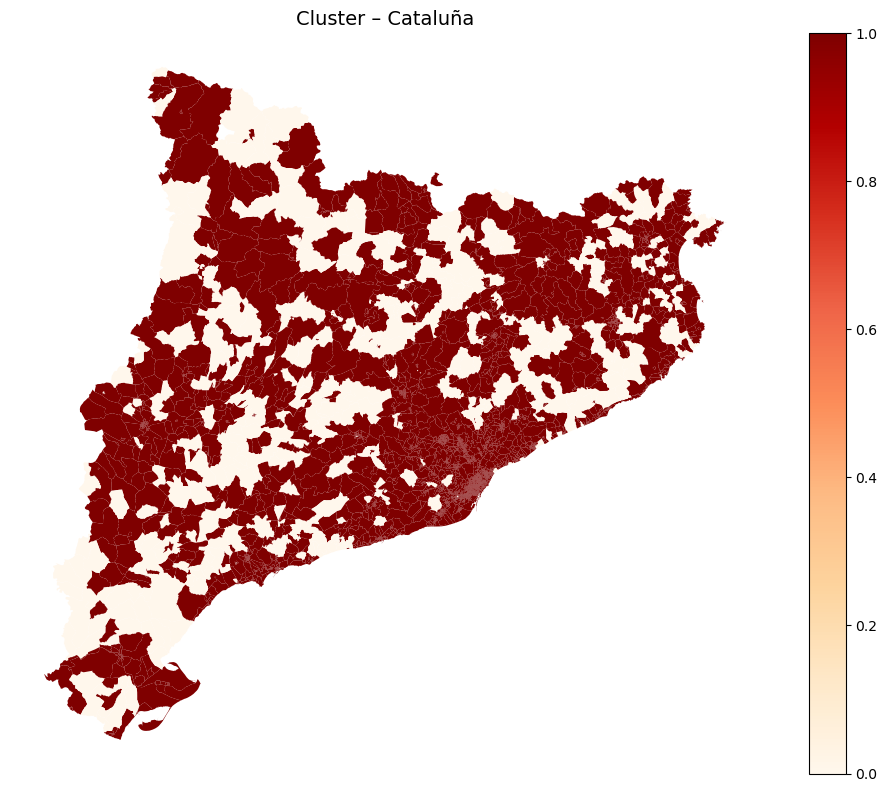

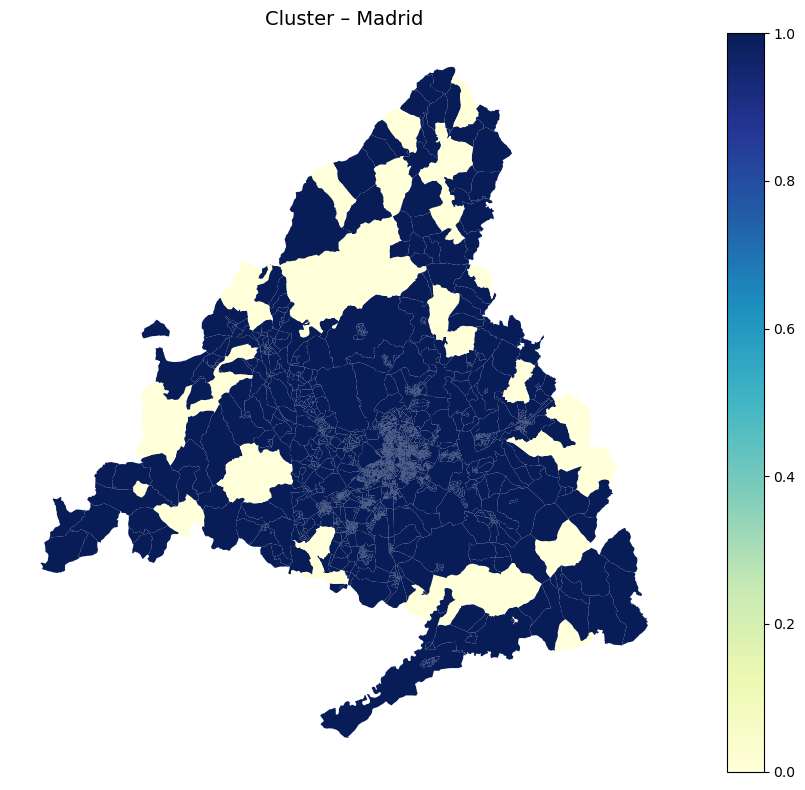

In [25]:
# Separar por provincia
resumen_cat = census_merged[census_merged['province'] == 'Cataluña']
resumen_mad = census_merged[census_merged['province'] == 'Madrid']

# Mapa de Cataluña
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
resumen_cat.plot(column='cluster', cmap='OrRd', linewidth=0.1, legend=True, ax=ax)
ax.set_title("Cluster – Cataluña", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

# Mapa de Madrid
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
resumen_mad.plot(column='cluster', cmap='YlGnBu', linewidth=0.1, legend=True, ax=ax)
ax.set_title("Cluster – Madrid", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()
